# Summary including the Business Problem and Data Understanding

This notebook dives into the world of Pnuemonia Detection using Neural Networks. Neural Networks are a great framework for processing image data since image data is quite complex. The stakeholder for this project will be a hospital who specialize in pneumonia care and would like to leverage technology in their day to day process. The information provided in this notebook was provided by kaggle at https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia. This was a less intensive version of the data from https://data.mendeley.com/datasets/rscbjbr9sj/2. The information came with a train, validation and test set, each with a folder labeled "NORMAL" and "PNEUMONIA". The validation set vastly lacked information, therefore, information from the train set was moved into the validation set before any processing or modeling preparations.

For the preparation section of this notebook, packages from sklearn, tensorflow, matplotlib, numpy, seaborn and os were used to complete this project. Tensorflow was used to model using neural networks while sklearn was used for evaluation. Numpy was key to converting information into arrays for the neural networks to process. Matplotlib and seaborn were used for visualization purposes. os was necessary to get the information from the local drive into this notebook. For the start of the preparation, we wanted to know how much information we were working with so there were counts of the information in each folder. There were also displays of examples of what was considered a normal xray and an xray for someone who had pneumonia. The dataset was normalized to work well with the neural network and a generator was used to prepare the information. Class weights were also calculated because the dataset was imalanced and needed to be addressed. 

During the modeling section of this notebook, there were iterative tweaks to the models to see how it will affect the performance towards achieving the goal of making a useful model. There were tweaks to nodes, optimizers, dropout and learning rates. There were also tweaks to fit parameters such as epochs and validation steps. The process started with a very basic neural network containing an input layer, hidden layer, and an output layer. An HParams search was used to go through different parameters inside of the neural network to see which will perform the best and then progressively tweak the neural network further. Afterwards, transfer learning was used in comparison to the tweaks of the model. Transfer learning ultimately succeeded to becoming the final model used on the test set since it had the most stable training loss and validation loss with a decent percentage of detection of pneumonia compared to other models.

Evaluating each model (except for the HParams model because it would be too resource intensive at the moment) was evaluated using a visualization of the training loss and the validation loss. An accompanying validation confusion matrix allowed for closer inspection as to how a model will perform in terms of its predictions.

The result of this project was unsuccessful in its detection ability and would need to continue to be worked on to further strengthen its ability to detect. The test set had a data imbalance of a 62.5% towards Pneumonia. Although the results for accuracy in the evaluate method of the test set provided by tensorflow was about ~73.2%, The best model in this notebook was only able to detect a Pneumonia patient who had it ~36.3% of the time and misdiagnosed a patient who actually had Pneumonia as Normal ~62.8 of the time.

# Data Preparation

In [1]:
#Importing the necessary packages
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

#Making the directories to access the information
train_directory= 'data/chest_xray/train'
validation_directory= 'data/chest_xray/val'
test_directory = 'data/chest_xray/test'

In [2]:
#Getting the counts for each directory
print("Train set:")
num_pneumonia = len(os.listdir(os.path.join(train_directory, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_directory, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")
print("\n")
print("Validation set:")
print(f'PNEUMONIA={len(os.listdir(os.path.join(validation_directory, "PNEUMONIA")))}')
print(f'NORMAL={len(os.listdir(os.path.join(validation_directory, "NORMAL")))}')
print("\n")
print('Test set:')
print(f'PNEUMONIA={len(os.listdir(os.path.join(test_directory, "PNEUMONIA")))}')
print(f'NORMAL={len(os.listdir(os.path.join(test_directory, "NORMAL")))}')

Train set:
PNEUMONIA=3575
NORMAL=1041


Validation set:
PNEUMONIA=308
NORMAL=308


Test set:
PNEUMONIA=390
NORMAL=234


Examples of a normal xray:
-------------------------------


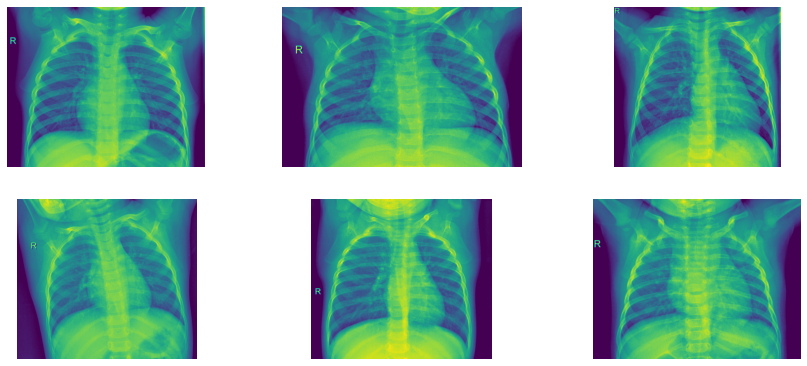

In [3]:
#Displaying examples of a normal xray
print('Examples of a normal xray:\n-------------------------------')
normal = os.listdir("data/chest_xray/train/NORMAL")
normal_directory = "data/chest_xray/train/NORMAL"

plt.figure(figsize = (15,10))
for i in range(6):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(normal_directory, normal[i]))
    plt.imshow(img)
    plt.axis('off')


Examples of a pneumonia xray:
-------------------------------


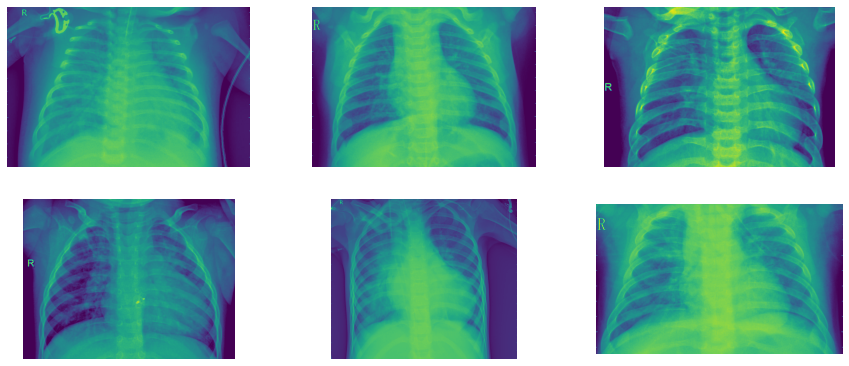

In [4]:
#Displaying examples of a pneumonia xray
print('Examples of a pneumonia xray:\n-------------------------------')
pneumonia = os.listdir("data/chest_xray/train/PNEUMONIA")
pneumonia_directory = "data/chest_xray/train/PNEUMONIA"

plt.figure(figsize = (15,10))
for i in range(6):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(pneumonia_directory, pneumonia[i]))
    plt.imshow(img)
    plt.axis('off')

In [5]:
#Normalizing the data
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

#Using a generator for the images to work with.
train_generator = train_datagen.flow_from_directory(train_directory,
                                                   target_size = (150, 150),
                                                   batch_size=20,
                                                   class_mode = 'binary')

validation_generator = val_datagen.flow_from_directory(validation_directory,
                                                      target_size = (150, 150),
                                                      batch_size = 20,
                                                      class_mode = 'binary')

Found 4616 images belonging to 2 classes.
Found 616 images belonging to 2 classes.


In [6]:
#Checking the classification of the information
train_generator.class_indices
validation_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [7]:
#Calculating class weights to deal with data imbalance
weight_for_0 = num_pneumonia / (num_normal + num_pneumonia) 
weight_for_1 = num_normal / (num_normal + num_pneumonia)
class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.77
Weight for class 1: 0.23


# Modeling

## Model 1 - Baseline

In [8]:
#Initializing Model
model_1 = models.Sequential()

#Adding CNN input layer
model_1.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
model_1.add(layers.MaxPooling2D(2,2))

#Adding Dense hidden layer
model_1.add(layers.Flatten())
model_1.add(layers.Dense(256, activation = 'relu'))

#Adding output layer with sigmoid for binary classification
model_1.add(layers.Dense(1, activation = 'sigmoid'))

#Compiling the model
model_1.compile(loss= 'binary_crossentropy', 
optimizer= optimizers.RMSprop(lr=1e-4), 
metrics=['acc'])
    
    

In [9]:
#Checking model summary to see how many params will be trained
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 175232)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               44859648  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 44,860,801
Trainable params: 44,860,801
Non-trainable params: 0
_________________________________________________________________


In [10]:
#Fitting model and adding class weights
history = model_1.fit(train_generator, #Using train data
                      epochs = 10, #Starting with 10 epochs
                      validation_data = validation_generator, #Using validation data
                      class_weight = class_weight, #Adding weights to deal with imbalance
                      steps_per_epoch = 100, #Starting with 100 steps
                      validation_steps = 10)#Starting with 10 validation steps

Epoch 1/10
100/100 [==============================] - 32s 315ms/step - loss: 0.2920 - acc: 0.6643 - val_loss: 0.3254 - val_acc: 0.8700
Epoch 2/10
100/100 [==============================] - 31s 314ms/step - loss: 0.1162 - acc: 0.8592 - val_loss: 0.2646 - val_acc: 0.8700
Epoch 3/10
100/100 [==============================] - 32s 321ms/step - loss: 0.0890 - acc: 0.8938 - val_loss: 0.2851 - val_acc: 0.8800
Epoch 4/10
100/100 [==============================] - 33s 328ms/step - loss: 0.0701 - acc: 0.9160 - val_loss: 0.2041 - val_acc: 0.9050
Epoch 5/10
100/100 [==============================] - 33s 326ms/step - loss: 0.0625 - acc: 0.9299 - val_loss: 0.1549 - val_acc: 0.9500
Epoch 6/10
100/100 [==============================] - 33s 326ms/step - loss: 0.0558 - acc: 0.9430 - val_loss: 0.2586 - val_acc: 0.8900
Epoch 7/10
100/100 [==============================] - 32s 324ms/step - loss: 0.0476 - acc: 0.9474 - val_loss: 0.1182 - val_acc: 0.9650
Epoch 8/10
100/100 [==============================] - 3

## Evaluation 1 - Baseline 1 hidden and dense layer

In [11]:
#Creating function to evaluate training loss and validation loss 
def evaluate_nn(history):
    '''
    This function plots the training accuracy, validation accuracy, training loss and validation loss from a fitted keras model.
    It gets this information from the history.history and the metric attributed to the model.
    
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'blue', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'blue', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'orange', label= 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()

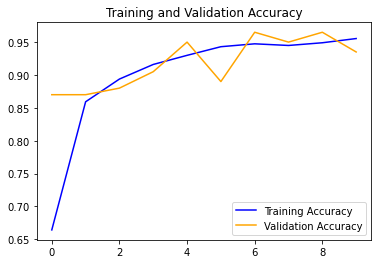

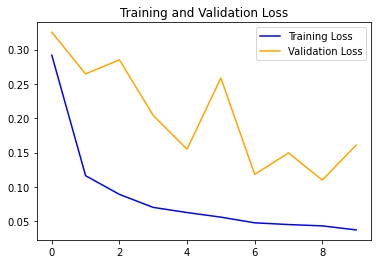

<Figure size 432x288 with 0 Axes>

In [12]:
#Evaluating the loss and accuracy of the model
evaluate_nn(history)

In [13]:
#Creating function to get a confusion matrix
def get_confusion_matrix(model, generator):
    '''
    This function gets a confusion matrix from a model that was fit on a keras generator. It will display the confusion matrix
    in its regular form for the classes that need to be predicted which in this case would be whether a patient
    has pneumonia or is normal. The probabilities produced from the prediction gets rounded either 0 or 1 and then gets counted
    into the confusion matrix as either a true positive(TP), false negative (FN), true negative(TN) or false positive(FP).
    '''
    #Generating labels (target)
    true_labels = generator.classes
    
    #Generating predictions
    predictions = model.predict(generator)
    
    #Adding target as a variable
    y_true = true_labels
    
    #Converting probabilities to 0 and 1
    y_pred = np.array([round(x[0]) for x in predictions])
    
    #Creating confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    return cm


In [14]:
#Creating a function to plot 
def plot_confusion_matrix(cm):
    '''
    This function plots a normalized confusion matrix. It takes in a confusion matrix generated from the get_confusion_matrix
    function and turns confusion matrix numbers into percentages for easier intepretation.
    
    '''
    #Calculating normalization
    row_sums = cm.sum(axis=1)
    new_matrix = np.round(cm / row_sums[:, np.newaxis], 3)
    
    #Plotting confusion matrix using heatmap
    fig, ax = plt.subplots(figsize = (16, 10))
    ax = sns.heatmap(new_matrix, annot=True, cmap='Blues', fmt='g')

    ax.set_title('Predictions for Pneumonia cases\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Normal','Pneumonia'])
    ax.yaxis.set_ticklabels(['Normal','Pneumonia'])

## Display the visualization of the Confusion Matrix.
plt.show();

### Validation predictions

In [15]:
#Getting the confusion matrix predictions from the model
cm1_val = get_confusion_matrix(model_1, validation_generator)
cm1_val

array([[143, 165],
       [140, 168]], dtype=int64)

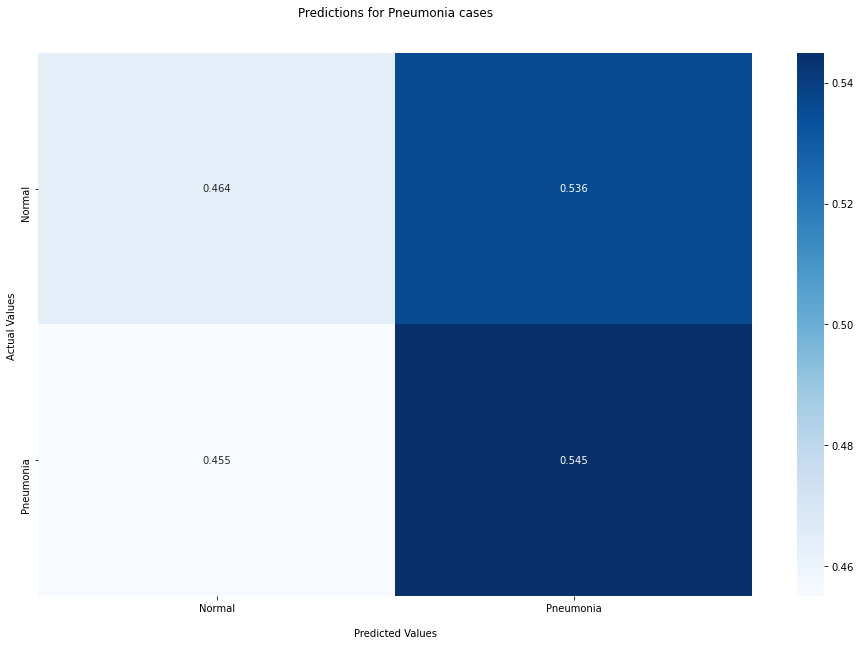

In [16]:
#Creating a plot for the confusion matrix
plot_confusion_matrix(cm1_val)

## Conclusion 1 - Baseline 1 hidden and dense layer

Extreme overfitting is occuring. Training is doing really well but there has to be a lot more tweaks done because validation accuracy and loss is all over the place. We have to make it more streamlined to have a better model overall.

## Model 2 - HParams

In [17]:
#Specifying the parameters inside of the neural network that should be searched through
HP_NUM_UNITS=hp.HParam('num_units', hp.Discrete([128, 256, 512]))
HP_DROPOUT=hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_LEARNING_RATE= hp.HParam('learning_rate', hp.Discrete([0.01, 0.05, 0.001]))
HP_OPTIMIZER=hp.HParam('optimizer', hp.Discrete(['adam', 'rmsprop']))
METRIC_ACCURACY='accuracy'
    

In [18]:
#Creating a directory for logs
logdir = 'logs/hparam_tuning'

In [19]:
#Creating a folder to keep written logs
with tf.summary.create_file_writer(logdir).as_default():
    hp.hparams_config(
    hparams=
    [HP_NUM_UNITS, HP_DROPOUT,  HP_OPTIMIZER, HP_LEARNING_RATE],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [21]:
#Creating function to do an HParams search
def create_model_grid(hparams):
    '''
    
    This function uses the baseline model as it's base model. It changes the nodes, optimizer, dropout and learning rate based 
    on the set params in the HParams. 
    
    '''
    #Initializing model
    model = models.Sequential()
    
    #Adding CNN input layer
    model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(hparams[HP_DROPOUT]))
    
    #Adding Dense hidden layer
    model.add(layers.Flatten())
    model.add(layers.Dense(hparams[HP_NUM_UNITS], activation = 'relu'))
    model.add(layers.Dropout(hparams[HP_DROPOUT]))
    
    #Adding output layer
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    #Looping through optimizers and learning rates
    optimizer = hparams[HP_OPTIMIZER]
    learning_rate = hparams[HP_LEARNING_RATE]
    if optimizer == "adam":
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer=='rmsprop':
        optimizer = tf.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("unexpected optimizer name: %r" % (optimizer_name,))
    
    #Compiling model
    model.compile(loss= 'binary_crossentropy', 
    optimizer= optimizer, 
    metrics=['acc'])
    
    #Fitting model
    history=model.fit(
    train_generator, #Using train data
    steps_per_epoch=100, #Keeping 100 steps
    epochs=10, #Keeping 10 epochs
    validation_data=validation_generator, #Using validation data
    class_weight = class_weight, #Adding weights to deal with imbalance
    validation_steps=10, #Keeping 10 steps
    )
    
    return history.history['val_acc'][-1]

In [22]:
#Recording the logs for each model generated
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = create_model_grid(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [23]:
#Looping through each Hparam with a different model
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
        for learning_rate in HP_LEARNING_RATE.domain.values:
          hparams = {
              HP_NUM_UNITS: num_units,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
              HP_LEARNING_RATE: learning_rate,
          }
          run_name = "run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          run('logs/hparam_tuning/' + run_name, hparams)
          session_num += 1

--- Starting trial: run-0
{'num_units': 128, 'dropout': 0.1, 'optimizer': 'adam', 'learning_rate': 0.001}
Epoch 1/10
100/100 [==============================] - 21s 210ms/step - loss: 0.2613 - acc: 0.8105 - val_loss: 0.2327 - val_acc: 0.9050
Epoch 2/10
100/100 [==============================] - 21s 207ms/step - loss: 0.0522 - acc: 0.9450 - val_loss: 0.1022 - val_acc: 0.9700
Epoch 3/10
100/100 [==============================] - 21s 205ms/step - loss: 0.0361 - acc: 0.9655 - val_loss: 0.1431 - val_acc: 0.9350
Epoch 4/10
100/100 [==============================] - 21s 209ms/step - loss: 0.0310 - acc: 0.9640 - val_loss: 0.0966 - val_acc: 0.9500
Epoch 5/10
100/100 [==============================] - 21s 211ms/step - loss: 0.0228 - acc: 0.9780 - val_loss: 0.1168 - val_acc: 0.9550
Epoch 6/10
100/100 [==============================] - 21s 209ms/step - loss: 0.0221 - acc: 0.9760 - val_loss: 0.2476 - val_acc: 0.8950
Epoch 7/10
100/100 [==============================] - 21s 210ms/step - loss: 0.0232 

Epoch 7/10
100/100 [==============================] - 25s 245ms/step - loss: 0.1851 - acc: 0.7976 - val_loss: 0.6647 - val_acc: 0.6300
Epoch 8/10
100/100 [==============================] - 24s 244ms/step - loss: 14.2043 - acc: 0.8201 - val_loss: 0.8607 - val_acc: 0.7900
Epoch 9/10
100/100 [==============================] - 24s 242ms/step - loss: 0.1572 - acc: 0.8582 - val_loss: 0.5947 - val_acc: 0.7050
Epoch 10/10
100/100 [==============================] - 24s 243ms/step - loss: 0.6340 - acc: 0.8545 - val_loss: 0.6178 - val_acc: 0.6600
--- Starting trial: run-6
{'num_units': 128, 'dropout': 0.2, 'optimizer': 'adam', 'learning_rate': 0.001}
Epoch 1/10
100/100 [==============================] - 21s 213ms/step - loss: 0.4590 - acc: 0.7129 - val_loss: 0.3638 - val_acc: 0.8900
Epoch 2/10
100/100 [==============================] - 21s 209ms/step - loss: 0.1058 - acc: 0.8552 - val_loss: 0.2754 - val_acc: 0.8950
Epoch 3/10
100/100 [==============================] - 21s 209ms/step - loss: 0.080

Epoch 3/10
100/100 [==============================] - 24s 242ms/step - loss: 0.6696 - acc: 0.7520 - val_loss: 0.6919 - val_acc: 0.5550
Epoch 4/10
100/100 [==============================] - 24s 242ms/step - loss: 0.2096 - acc: 0.6970 - val_loss: 0.6168 - val_acc: 0.6150
Epoch 5/10
100/100 [==============================] - 24s 244ms/step - loss: 2.7896 - acc: 0.7880 - val_loss: 0.7186 - val_acc: 0.6000
Epoch 6/10
100/100 [==============================] - 24s 244ms/step - loss: 0.2078 - acc: 0.7155 - val_loss: 0.6802 - val_acc: 0.5000
Epoch 7/10
100/100 [==============================] - 24s 243ms/step - loss: 0.2013 - acc: 0.7310 - val_loss: 0.6853 - val_acc: 0.5400
Epoch 8/10
100/100 [==============================] - 24s 243ms/step - loss: 0.2707 - acc: 0.6954 - val_loss: 0.6924 - val_acc: 0.7150
Epoch 9/10
100/100 [==============================] - 24s 244ms/step - loss: 0.1905 - acc: 0.7620 - val_loss: 0.6306 - val_acc: 0.6100
Epoch 10/10
100/100 [==============================] - 

100/100 [==============================] - 33s 333ms/step - loss: 2.5894 - acc: 0.8545 - val_loss: 0.2827 - val_acc: 0.9000
Epoch 10/10
100/100 [==============================] - 33s 333ms/step - loss: 0.9204 - acc: 0.8231 - val_loss: 0.5464 - val_acc: 0.8850
--- Starting trial: run-17
{'num_units': 256, 'dropout': 0.1, 'optimizer': 'rmsprop', 'learning_rate': 0.05}
Epoch 1/10
100/100 [==============================] - 34s 342ms/step - loss: 949.9250 - acc: 0.7495 - val_loss: 0.8834 - val_acc: 0.7050
Epoch 2/10
100/100 [==============================] - 34s 339ms/step - loss: 0.2121 - acc: 0.7570 - val_loss: 0.6592 - val_acc: 0.5350
Epoch 3/10
100/100 [==============================] - 34s 340ms/step - loss: 2.8032 - acc: 0.7540 - val_loss: 0.6123 - val_acc: 0.6900
Epoch 4/10
100/100 [==============================] - 34s 337ms/step - loss: 0.1965 - acc: 0.7355 - val_loss: 0.6176 - val_acc: 0.6200
Epoch 5/10
100/100 [==============================] - 34s 339ms/step - loss: 0.2373 - acc

Epoch 5/10
100/100 [==============================] - 33s 332ms/step - loss: 0.2387 - acc: 0.6400 - val_loss: 0.6941 - val_acc: 0.4700
Epoch 6/10
100/100 [==============================] - 33s 333ms/step - loss: 0.2464 - acc: 0.4649 - val_loss: 0.6939 - val_acc: 0.4950
Epoch 7/10
100/100 [==============================] - 33s 333ms/step - loss: 0.2403 - acc: 0.4404 - val_loss: 0.6944 - val_acc: 0.4700
Epoch 8/10
100/100 [==============================] - 33s 334ms/step - loss: 0.2429 - acc: 0.5787 - val_loss: 0.6931 - val_acc: 0.5050
Epoch 9/10
100/100 [==============================] - 33s 331ms/step - loss: 0.2406 - acc: 0.4900 - val_loss: 0.6931 - val_acc: 0.5050
Epoch 10/10
100/100 [==============================] - 33s 334ms/step - loss: 0.2394 - acc: 0.7740 - val_loss: 0.6951 - val_acc: 0.4800
--- Starting trial: run-23
{'num_units': 256, 'dropout': 0.2, 'optimizer': 'rmsprop', 'learning_rate': 0.05}
Epoch 1/10
100/100 [==============================] - 33s 331ms/step - loss: 194

Epoch 1/10
100/100 [==============================] - 53s 534ms/step - loss: 21.5992 - acc: 0.7670 - val_loss: 0.3784 - val_acc: 0.8100
Epoch 2/10
100/100 [==============================] - 53s 531ms/step - loss: 7.6321 - acc: 0.7791 - val_loss: 0.5508 - val_acc: 0.8450
Epoch 3/10
100/100 [==============================] - 53s 531ms/step - loss: 2.1906 - acc: 0.7771 - val_loss: 8.4138 - val_acc: 0.5200
Epoch 4/10
100/100 [==============================] - 53s 532ms/step - loss: 2.4640 - acc: 0.7930 - val_loss: 0.3845 - val_acc: 0.8750
Epoch 5/10
100/100 [==============================] - 53s 532ms/step - loss: 0.6897 - acc: 0.8720 - val_loss: 0.4267 - val_acc: 0.8750
Epoch 6/10
100/100 [==============================] - 53s 529ms/step - loss: 1.7098 - acc: 0.8515 - val_loss: 0.2274 - val_acc: 0.8650
Epoch 7/10
100/100 [==============================] - 53s 530ms/step - loss: 1.9577 - acc: 0.8580 - val_loss: 145.8890 - val_acc: 0.5100
Epoch 8/10
100/100 [==============================] 

100/100 [==============================] - 52s 525ms/step - loss: 0.0718 - acc: 0.9600 - val_loss: 0.3433 - val_acc: 0.8850
Epoch 8/10
100/100 [==============================] - 52s 525ms/step - loss: 0.0535 - acc: 0.9549 - val_loss: 0.3553 - val_acc: 0.9000
Epoch 9/10
100/100 [==============================] - 53s 526ms/step - loss: 0.0521 - acc: 0.9665 - val_loss: 0.1738 - val_acc: 0.9400
Epoch 10/10
100/100 [==============================] - 53s 525ms/step - loss: 0.0278 - acc: 0.9780 - val_loss: 0.1073 - val_acc: 0.9750
--- Starting trial: run-34
{'num_units': 512, 'dropout': 0.2, 'optimizer': 'rmsprop', 'learning_rate': 0.01}
Epoch 1/10
100/100 [==============================] - 53s 527ms/step - loss: 38.9778 - acc: 0.5680 - val_loss: 0.7344 - val_acc: 0.4900
Epoch 2/10
100/100 [==============================] - 52s 524ms/step - loss: 0.2647 - acc: 0.5565 - val_loss: 0.6933 - val_acc: 0.4850
Epoch 3/10
100/100 [==============================] - 52s 523ms/step - loss: 0.2417 - acc:

## Model 3

After the HParams search, the best model in terms of the consistent val_acc score would be the model that has:
* One input CNN layer: Node = 32
* One Dense hidden layer: Node = 128
* One Dense output layer: Node = 1
* Optimizer = Adam
* Dropout = 0.2
* Learning rate = 0.001

With this model, it will be adjusted with: 
* A lower learning rate: 1e-4
* An additional CNN layer with same parameters as input

In [24]:
#Initializing model
model_3 = models.Sequential()

#Adding CNN input layer
model_3.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
model_3.add(layers.MaxPooling2D(2,2))
model_3.add(layers.Dropout(0.2))

#Adding CNN hidden layer
model_3.add(layers.Conv2D(32, (3,3), activation = 'relu'))
model_3.add(layers.MaxPooling2D(2,2))
model_3.add(layers.Dropout(0.2))

#Flattening and adding another Dense hidden layer
model_3.add(layers.Flatten())
model_3.add(layers.Dense(128, activation = 'relu'))
model_3.add(layers.Dropout(0.2))

#Adding output layer
model_3.add(layers.Dense(1, activation = 'sigmoid'))

#Compiling model
model_3.compile(loss= 'binary_crossentropy', 
optimizer= optimizers.Adam(lr=1e-4), 
metrics=['acc'])

In [25]:
#Checking model summary to see how many params will be trained
model_3.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_37 (Flatten)         (None, 41472)           

In [26]:
#Fitting model to the data
history_3=model_3.fit(
    train_generator, #Using train data
    steps_per_epoch=100, #Staying with 100 steps per epoch
    epochs=10, #Staying with starting epoch
    validation_data=validation_generator, #Using validation data
    class_weight = class_weight, ##Adding weights to deal with imbalance
    validation_steps=10) #Staying with 10 steps

Epoch 1/10
100/100 [==============================] - 21s 208ms/step - loss: 0.2077 - acc: 0.7029 - val_loss: 0.5440 - val_acc: 0.7600
Epoch 2/10
100/100 [==============================] - 22s 217ms/step - loss: 0.1150 - acc: 0.8750 - val_loss: 0.3173 - val_acc: 0.8500
Epoch 3/10
100/100 [==============================] - 21s 215ms/step - loss: 0.0760 - acc: 0.9120 - val_loss: 0.2268 - val_acc: 0.9050
Epoch 4/10
100/100 [==============================] - 21s 211ms/step - loss: 0.0691 - acc: 0.9205 - val_loss: 0.2656 - val_acc: 0.9000
Epoch 5/10
100/100 [==============================] - 21s 206ms/step - loss: 0.0570 - acc: 0.9365 - val_loss: 0.1636 - val_acc: 0.9400
Epoch 6/10
100/100 [==============================] - 21s 210ms/step - loss: 0.0480 - acc: 0.9435 - val_loss: 0.2145 - val_acc: 0.9050
Epoch 7/10
100/100 [==============================] - 21s 208ms/step - loss: 0.0455 - acc: 0.9505 - val_loss: 0.1261 - val_acc: 0.9600
Epoch 8/10
100/100 [==============================] - 2

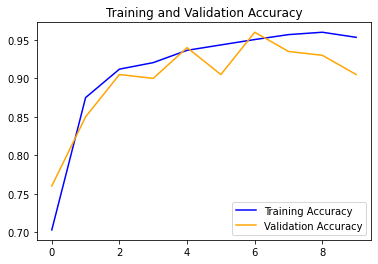

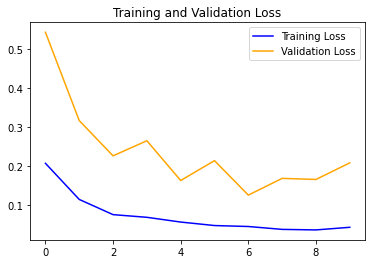

<Figure size 432x288 with 0 Axes>

In [27]:
#Evaluating the loss and accuracy of the model
evaluate_nn(history_3)

### Validation Predictions

In [28]:
#Getting the confusion matrix predictions from the model
cm3_val = get_confusion_matrix(model_3, validation_generator)
cm3_val

array([[137, 171],
       [124, 184]], dtype=int64)

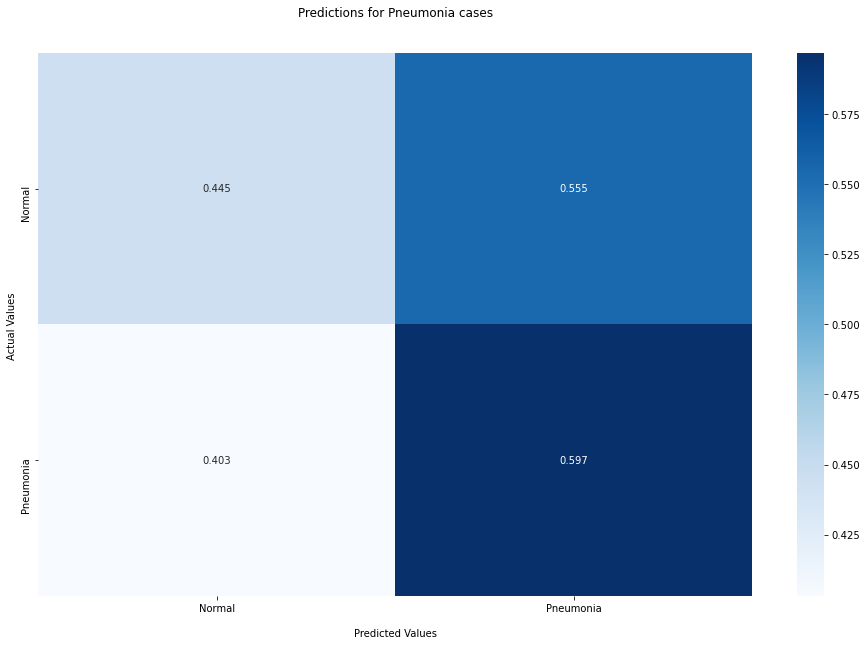

In [29]:
#Creating a plot for the confusion matrix
plot_confusion_matrix(cm3_val)

## Model 4

Using the best model from HParam search:
* One input CNN layer: Node = 32
* One Dense hidden layer: Node = 128
* One Dense output layer: Node = 1
* Optimizer = Adam
* Node = 128
* Dropout = 0.2
* Learning rate = 0.001

Keeping these parameters and adjusting the fit parameters to: 
* Add more epochs: 30 
* Add more validation steps: 25

In [30]:
#Initializing model
model_4 = models.Sequential()

#Adding CNN input layer
model_4.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
model_4.add(layers.MaxPooling2D(2,2))
model_4.add(layers.Dropout(0.2))

#Flattening and adding Dense hidden layer
model_4.add(layers.Flatten())
model_4.add(layers.Dense(128, activation = 'relu'))
model_4.add(layers.Dropout(0.2))

#Adding output layer
model_4.add(layers.Dense(1, activation = 'sigmoid'))

#Compiling model
model_4.compile(loss= 'binary_crossentropy', 
optimizer= optimizers.Adam(lr=0.001), 
metrics=['acc'])

In [31]:
#Checking model summary to see how many params will be trained
model_4.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_75 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 175232)            0         
_________________________________________________________________
dense_76 (Dense)             (None, 128)               22429824  
_________________________________________________________________
dropout_76 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 1)               

In [32]:
#Fitting model
history_4=model_4.fit(
    train_generator, #Using train data
    steps_per_epoch=100, #Keeping 100 steps 
    epochs=30, #Increasing to 30 epochs
    validation_data=validation_generator, #Using validation data
    class_weight = class_weight, #Adding weights to deal with imbalance
    validation_steps=25) #Increasing to 25 steps

Epoch 1/30
100/100 [==============================] - 24s 243ms/step - loss: 0.2440 - acc: 0.8185 - val_loss: 0.2386 - val_acc: 0.8980
Epoch 2/30
100/100 [==============================] - 24s 241ms/step - loss: 0.0589 - acc: 0.9404 - val_loss: 0.1236 - val_acc: 0.9580
Epoch 3/30
100/100 [==============================] - 24s 240ms/step - loss: 0.0442 - acc: 0.9534 - val_loss: 0.1038 - val_acc: 0.9660
Epoch 4/30
100/100 [==============================] - 24s 243ms/step - loss: 0.0435 - acc: 0.9530 - val_loss: 0.1044 - val_acc: 0.9580
Epoch 5/30
100/100 [==============================] - 24s 242ms/step - loss: 0.0258 - acc: 0.9744 - val_loss: 0.1164 - val_acc: 0.9560
Epoch 6/30
100/100 [==============================] - 24s 240ms/step - loss: 0.0261 - acc: 0.9710 - val_loss: 0.0905 - val_acc: 0.9760
Epoch 7/30
100/100 [==============================] - 24s 239ms/step - loss: 0.0235 - acc: 0.9765 - val_loss: 0.1175 - val_acc: 0.9580
Epoch 8/30
100/100 [==============================] - 2

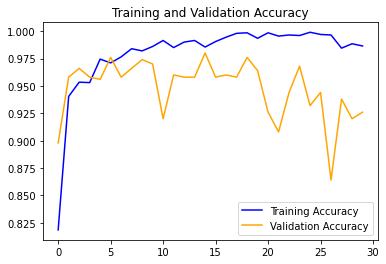

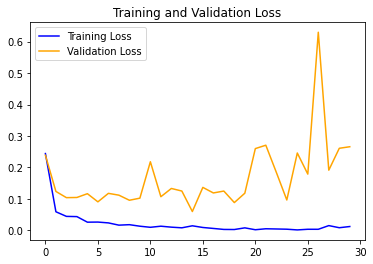

<Figure size 432x288 with 0 Axes>

In [33]:
#Evaluating the loss and accuracy of the model
evaluate_nn(history_4)

### Validation Predictions

In [34]:
#Getting the confusion matrix predictions from the model
cm4_val = get_confusion_matrix(model_4, validation_generator)
cm4_val

array([[140, 168],
       [127, 181]], dtype=int64)

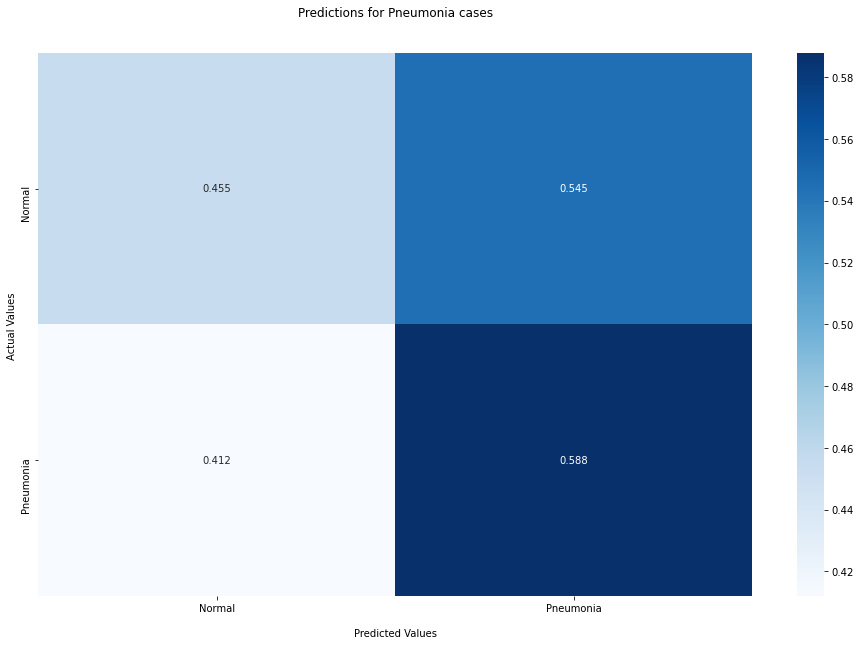

In [35]:
#Creating a plot for the confusion matrix
plot_confusion_matrix(cm4_val)

## Model 5

Using the best model from HParam search:
* One input CNN layer: Node = 32
* One Dense hidden layer: Node = 128
* One Dense output layer: Node = 1
* Optimizer = Adam
* Node = 128
* Dropout = 0.2
* Learning rate = 0.001

Keeping these parameters 
* epochs: 30 
* validation steps: 25
    
Adjusting model with: 
* An additional CNN layer with half nodes
* An additional Dense layer with double nodes



In [36]:
#Initializing model
model_5 = models.Sequential()

#Adding CNN input layer
model_5.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
model_5.add(layers.MaxPooling2D(2,2))
model_5.add(layers.Dropout(0.2))

#Adding CNN hidden layer
model_5.add(layers.Conv2D(16, (3,3), activation = 'relu'))
model_5.add(layers.MaxPooling2D(2,2))
model_5.add(layers.Dropout(0.2))

#Flattening and adding Dense hidden layer
model_5.add(layers.Flatten())
model_5.add(layers.Dense(256, activation = 'relu'))
model_5.add(layers.Dropout(0.2))

#Adding Dense hidden layer
model_5.add(layers.Dense(128, activation = 'relu'))
model_5.add(layers.Dropout(0.2))

#Adding output layer
model_5.add(layers.Dense(1, activation = 'sigmoid'))
    
model_5.compile(loss= 'binary_crossentropy', 
optimizer= optimizers.Adam(lr=0.001), 
metrics=['acc'])

In [37]:
#Checking model summary to see how many params will be trained
model_5.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_77 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 72, 72, 16)        4624      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 36, 36, 16)        0         
_________________________________________________________________
dropout_78 (Dropout)         (None, 36, 36, 16)        0         
_________________________________________________________________
flatten_39 (Flatten)         (None, 20736)           

In [38]:
#Fitting model
history_5=model_5.fit(
    train_generator, #Using train data
    steps_per_epoch=100, #Keeping 100 steps
    epochs=30, #Keeping 30 epochs
    validation_data=validation_generator, #Using validation data
    class_weight = class_weight, #Adding weight to deal with imbalance
    validation_steps=25) #Keeping 25 steps

Epoch 1/30
100/100 [==============================] - 23s 225ms/step - loss: 0.1780 - acc: 0.7830 - val_loss: 0.3071 - val_acc: 0.8780
Epoch 2/30
100/100 [==============================] - 22s 223ms/step - loss: 0.0713 - acc: 0.9205 - val_loss: 0.2441 - val_acc: 0.9060
Epoch 3/30
100/100 [==============================] - 22s 221ms/step - loss: 0.0489 - acc: 0.9474 - val_loss: 0.1955 - val_acc: 0.9340
Epoch 4/30
100/100 [==============================] - 22s 218ms/step - loss: 0.0511 - acc: 0.9495 - val_loss: 0.1322 - val_acc: 0.9600
Epoch 5/30
100/100 [==============================] - 23s 225ms/step - loss: 0.0466 - acc: 0.9529 - val_loss: 0.1817 - val_acc: 0.9380
Epoch 6/30
100/100 [==============================] - 22s 223ms/step - loss: 0.0524 - acc: 0.9454 - val_loss: 0.4019 - val_acc: 0.8520
Epoch 7/30
100/100 [==============================] - 23s 226ms/step - loss: 0.0422 - acc: 0.9615 - val_loss: 0.1194 - val_acc: 0.9620
Epoch 8/30
100/100 [==============================] - 2

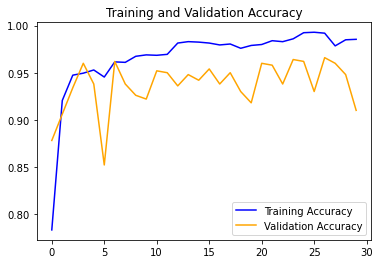

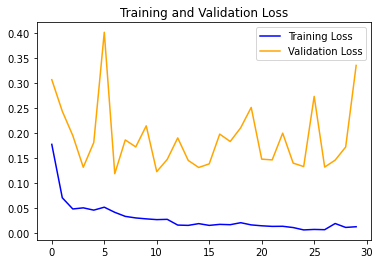

<Figure size 432x288 with 0 Axes>

In [39]:
#Evaluating the loss and accuracy of the model
evaluate_nn(history_5)

### Validation Predictions

In [40]:
#Getting the confusion matrix predictions from the model
cm5_val = get_confusion_matrix(model_5, validation_generator)
cm5_val

array([[139, 169],
       [140, 168]], dtype=int64)

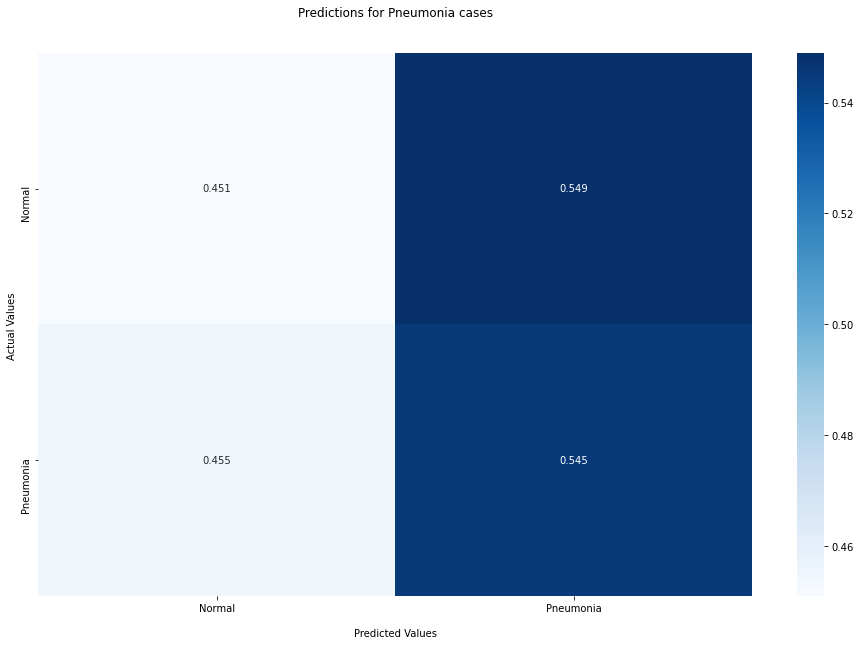

In [41]:
#Creating a plot for the confusion matrix
plot_confusion_matrix(cm5_val)

## Model 6

Using the best model from HParam search:
* One CNN layer: Node = 32
* One Dense hidden layer: Node = 128
* One Dense output layer: Node = 1
* Optimizer = Adam
* Node = 128
* Dropout = 0.2
* Learning rate = 0.001

Keeping these parameters 
* epochs: 30 
* validation steps: 25
    
Adjusting model with: 
* A new input CNN layer with double nodes
* An additional CNN layer with half nodes
* An additional Dense layer with double nodes
* An additional Dense layer with half nodes

In [42]:
#Initializing model
model_6 = models.Sequential()

#Adding CNN input layer
model_6.add(layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
model_6.add(layers.MaxPooling2D(2,2))
model_6.add(layers.Dropout(0.2))

#Adding CNN hidden layer
model_6.add(layers.Conv2D(32, (3,3), activation = 'relu'))
model_6.add(layers.MaxPooling2D(2,2))
model_6.add(layers.Dropout(0.2))

#Adding CNN hidden layer
model_6.add(layers.Conv2D(16, (3,3), activation = 'relu'))
model_6.add(layers.MaxPooling2D(2,2))
model_6.add(layers.Dropout(0.2))

#Flattening and adding Dense hidden layer
model_6.add(layers.Flatten())
model_6.add(layers.Dense(256, activation = 'relu'))
model_6.add(layers.Dropout(0.2))

#Adding Dense hidden layer
model_6.add(layers.Dense(128, activation = 'relu'))
model_6.add(layers.Dropout(0.2))

#Adding Dense hidden layer
model_6.add(layers.Dense(64, activation = 'relu'))
model_6.add(layers.Dropout(0.2))

#Adding output layer
model_6.add(layers.Dense(1, activation = 'sigmoid'))
    
#Compiling model
model_6.compile(loss= 'binary_crossentropy', 
optimizer= optimizers.Adam(lr=0.001), 
metrics=['acc'])

In [43]:
#Checking model summary to see how many params will be trained
model_6.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 72, 72, 32)        18464     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_82 (Dropout)         (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 34, 34, 16)      

In [44]:
#Fitting model
history_6=model_6.fit(
    train_generator, #Using train data
    steps_per_epoch=100, #Keeping 100 steps
    epochs=50, #Increasing to 50 epochs
    validation_data=validation_generator, #Using validation data
    class_weight = class_weight, #Adding weights to deal with imbalance
    validation_steps=25) #Keeping 25 steps

Epoch 1/50
100/100 [==============================] - 28s 278ms/step - loss: 0.2427 - acc: 0.3870 - val_loss: 0.6542 - val_acc: 0.7960
Epoch 2/50
100/100 [==============================] - 27s 270ms/step - loss: 0.1408 - acc: 0.8322 - val_loss: 0.5282 - val_acc: 0.8420
Epoch 3/50
100/100 [==============================] - 27s 273ms/step - loss: 0.1141 - acc: 0.8637 - val_loss: 0.3708 - val_acc: 0.8520
Epoch 4/50
100/100 [==============================] - 27s 273ms/step - loss: 0.0714 - acc: 0.9243 - val_loss: 0.1507 - val_acc: 0.9460
Epoch 5/50
100/100 [==============================] - 27s 272ms/step - loss: 0.0623 - acc: 0.9289 - val_loss: 0.1320 - val_acc: 0.9500
Epoch 6/50
100/100 [==============================] - 27s 273ms/step - loss: 0.0602 - acc: 0.9360 - val_loss: 0.1598 - val_acc: 0.9440
Epoch 7/50
100/100 [==============================] - 27s 272ms/step - loss: 0.0529 - acc: 0.9410 - val_loss: 0.0962 - val_acc: 0.9620
Epoch 8/50
100/100 [==============================] - 2

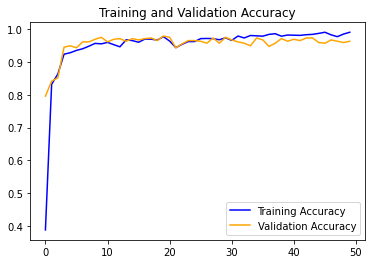

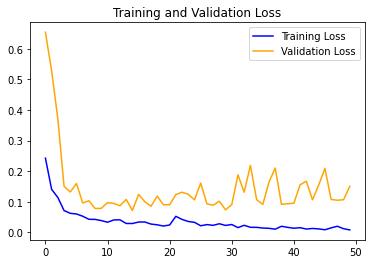

<Figure size 432x288 with 0 Axes>

In [45]:
#Evaluating the loss and accuracy of the model
evaluate_nn(history_6)

### Validation Predictions

In [46]:
#Getting the confusion matrix predictions from the model
cm6_val = get_confusion_matrix(model_6, validation_generator)
cm6_val

array([[129, 179],
       [162, 146]], dtype=int64)

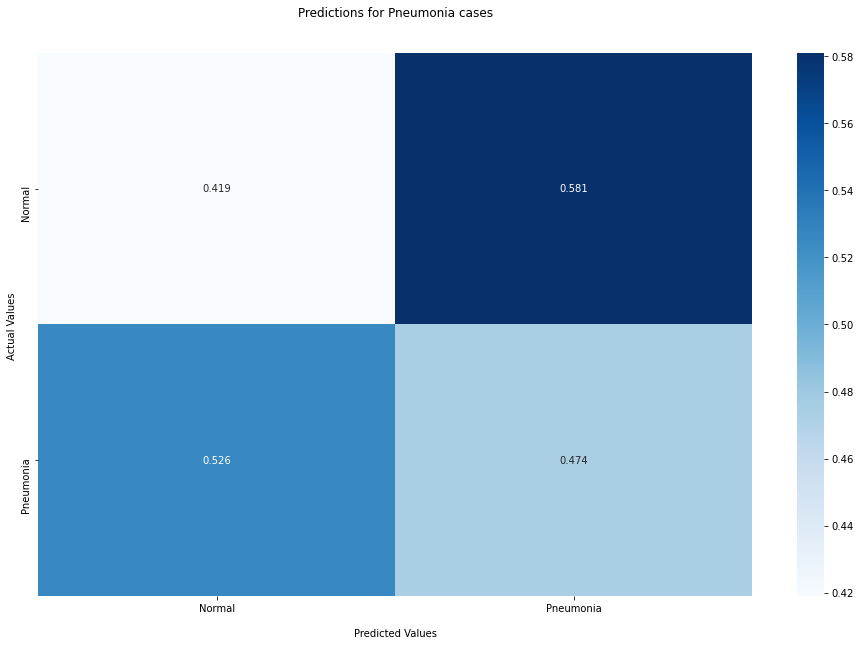

In [47]:
#Creating a plot for the confusion matrix
plot_confusion_matrix(cm6_val)

## Model 7 - Transfer Learning

Using the ResNet50 model with:
* One Dense hidden layer: Node = 256
* One Dense output layer: Node = 1

Keeping this parameter 
* validation steps: 25

Adding:
* epochs = 50

In [48]:
#Initializing model
resnet_model = models.Sequential()

#Adding pretrained resnet50 model to a variable
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(150,150,3),
                   pooling='avg',classes=1,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

#Adding pretrained model as a layer 
resnet_model.add(pretrained_model)

In [49]:
#Flattening layer and adding Dense hidden layer
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(256, activation='relu'))

#Adding output layer
resnet_model.add(layers.Dense(1, activation='sigmoid'))

In [50]:
#Checking model summary to see how many params will be trained
resnet_model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_41 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_85 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 257       
Total params: 24,112,513
Trainable params: 524,801
Non-trainable params: 23,587,712
_________________________________________________________________


In [51]:
#Compiling model
resnet_model.compile(optimizer=optimizers.Adam(lr=0.001),
                     loss='binary_crossentropy',
                     metrics=['acc'])

#Fitting model
history_7 = resnet_model.fit(train_generator, #Using train data
                             steps_per_epoch=100, #Keeping 100 steps
                             validation_data=validation_generator, #Using validation data
                             class_weight = class_weight, #Adding weights to deal with imbalance
                             epochs=50, #Keeping 50 epochs
                             validation_steps=25 #Keeping 25 steps
                          )

Epoch 1/50
100/100 [==============================] - 34s 339ms/step - loss: 0.2446 - acc: 0.5927 - val_loss: 0.6010 - val_acc: 0.8200
Epoch 2/50
100/100 [==============================] - 36s 355ms/step - loss: 0.2109 - acc: 0.6830 - val_loss: 0.5372 - val_acc: 0.8460
Epoch 3/50
100/100 [==============================] - 36s 355ms/step - loss: 0.1851 - acc: 0.7510 - val_loss: 0.4870 - val_acc: 0.8480
Epoch 4/50
100/100 [==============================] - 35s 354ms/step - loss: 0.1652 - acc: 0.7991 - val_loss: 0.4372 - val_acc: 0.8560
Epoch 5/50
100/100 [==============================] - 36s 355ms/step - loss: 0.1497 - acc: 0.8080 - val_loss: 0.3919 - val_acc: 0.8780
Epoch 6/50
100/100 [==============================] - 36s 355ms/step - loss: 0.1458 - acc: 0.8080 - val_loss: 0.3534 - val_acc: 0.8660
Epoch 7/50
100/100 [==============================] - 36s 356ms/step - loss: 0.1361 - acc: 0.8270 - val_loss: 0.3387 - val_acc: 0.8880
Epoch 8/50
100/100 [==============================] - 3

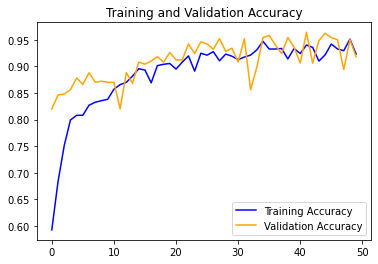

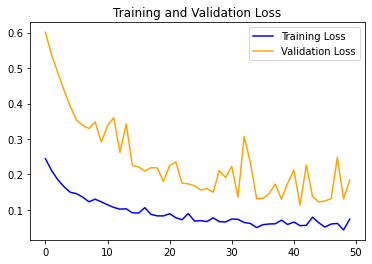

<Figure size 432x288 with 0 Axes>

In [52]:
#Evaluating the loss and accuracy of the model
evaluate_nn(history_7)

### Validation Predictions

In [53]:
#Getting the confusion matrix predictions from the model
cm7_val = get_confusion_matrix(resnet_model, validation_generator)
cm7_val

array([[135, 173],
       [133, 175]], dtype=int64)

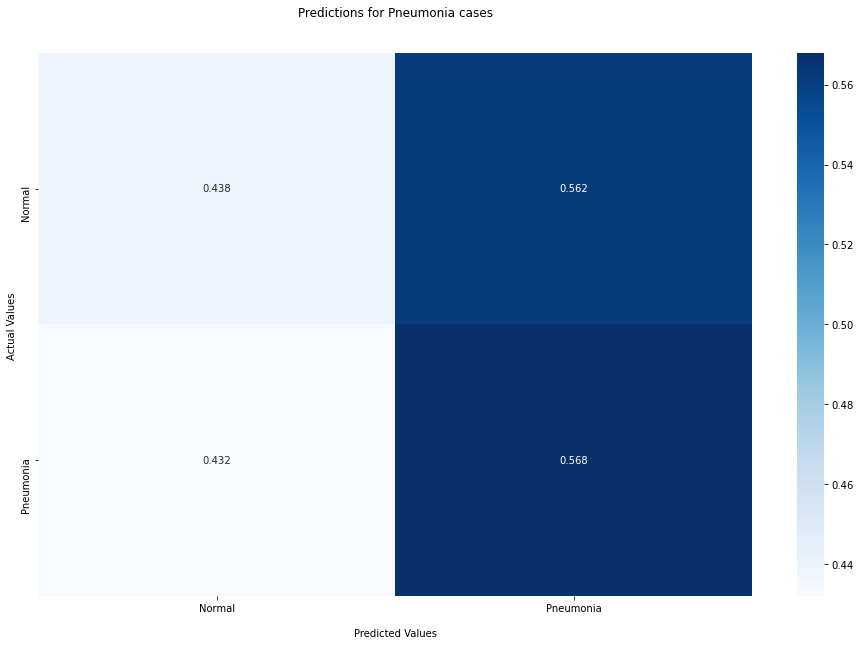

In [54]:
#Creating a plot for the confusion matrix
plot_confusion_matrix(cm7_val)

## Model 8 - Data Augmentation

Using the ResNet50 model with:
* One Dense hidden layer: Node = 256
* One Dense output layer: Node = 1

Keeping these parameters
* epochs = 50
* validation steps: 25

Adding:
* Data Augmentation to the generators


In [55]:
#Creating augmented train data 
train_datagen_aug = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

#Creating train generator with augmented train data
train_generator_aug = train_datagen_aug.flow_from_directory(train_directory,
                                                   target_size = (150, 150),
                                                    batch_size = 20,
                                                    class_mode = 'binary')

#Creating augmented validation data
val_datagen_aug = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

##Creating validation generator with augmented validation data
validation_generator_aug = val_datagen_aug.flow_from_directory(validation_directory,
                                                      target_size = (150, 150),
                                                      batch_size = 20,
                                                      class_mode = 'binary')


#Fitting resnet50 model to augmented data
history_8 = resnet_model.fit(
    train_generator_aug, #Using augmented train data
    steps_per_epoch=100, #Keeping 100 steps
    epochs=50, #Keeping 50 epochs
    validation_data=validation_generator_aug, #Using augmented validation data
    class_weight = class_weight, #Adding weights to deal with imbalance
    validation_steps=25) #Keeping 25 steps

Found 4616 images belonging to 2 classes.
Found 616 images belonging to 2 classes.
Epoch 1/50
100/100 [==============================] - 42s 422ms/step - loss: 0.2076 - acc: 0.7310 - val_loss: 0.4766 - val_acc: 0.7900
Epoch 2/50
100/100 [==============================] - 42s 424ms/step - loss: 0.1775 - acc: 0.7610 - val_loss: 0.5351 - val_acc: 0.7160
Epoch 3/50
100/100 [==============================] - 42s 421ms/step - loss: 0.1814 - acc: 0.7415 - val_loss: 0.4561 - val_acc: 0.8080
Epoch 4/50
100/100 [==============================] - 42s 423ms/step - loss: 0.1914 - acc: 0.7270 - val_loss: 0.5002 - val_acc: 0.7320
Epoch 5/50
100/100 [==============================] - 42s 419ms/step - loss: 0.1710 - acc: 0.7685 - val_loss: 0.4823 - val_acc: 0.7660
Epoch 6/50
100/100 [==============================] - 42s 422ms/step - loss: 0.1841 - acc: 0.7350 - val_loss: 0.4538 - val_acc: 0.7920
Epoch 7/50
100/100 [==============================] - 42s 424ms/step - loss: 0.1710 - acc: 0.7680 - val_los

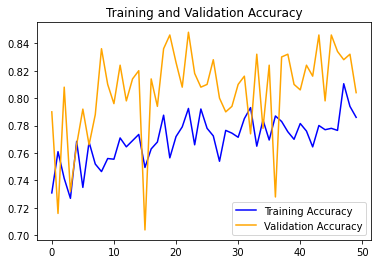

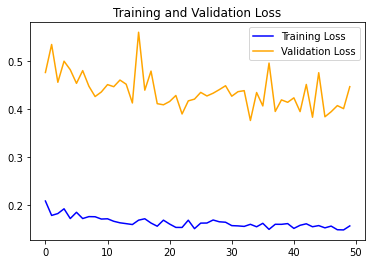

<Figure size 432x288 with 0 Axes>

In [56]:
#Evaluating the loss and accuracy of the model
evaluate_nn(history_8)

### Validation Predictions

In [57]:
#Getting the confusion matrix predictions from the model
cm8_val = get_confusion_matrix(resnet_model, validation_generator_aug)
cm8_val

array([[210,  98],
       [205, 103]], dtype=int64)

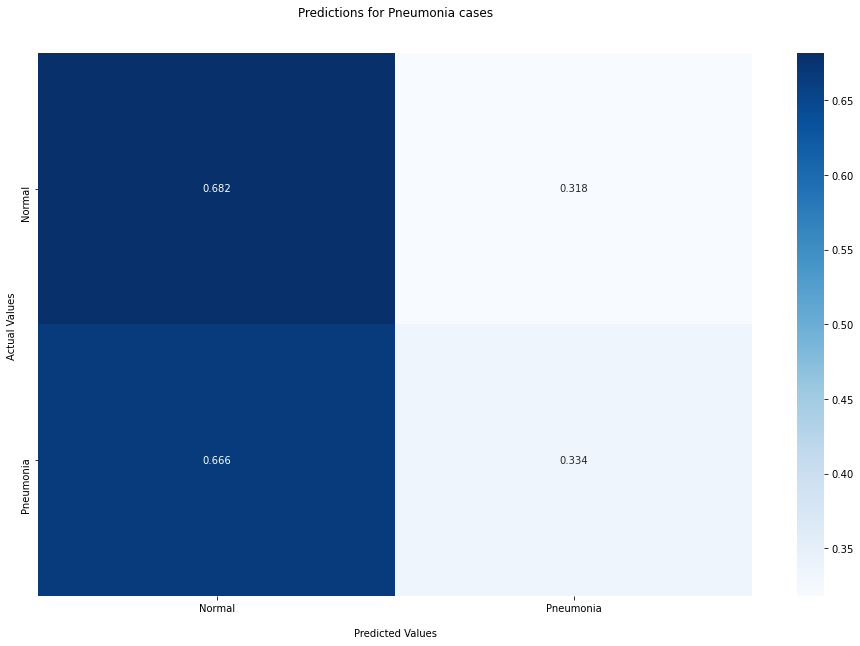

In [58]:
#Creating a plot for the confusion matrix
plot_confusion_matrix(cm8_val)

## Model 9 

Using baseline model:
* One input CNN layer: Node = 32
* One Dense hidden layer: Node = 256
* One Dense output layer: Node = 1
* Optimizer = RMSProp
* Learning rate = 1e-4

With this model, it will be adjusted with: 
* Different regularizer = L2(0.001)

In [59]:
from tensorflow.keras import regularizers

#Initializing model
model_9 = models.Sequential()

#Adding CNN input layer with L2
model_9.add(layers.Conv2D(32, (3,3), activation = 'relu', kernel_regularizer=regularizers.l2(0.001), input_shape = (150, 150, 3)))
model_9.add(layers.MaxPooling2D(2,2))

#Flattening and adding Dense layer with L2
model_9.add(layers.Flatten())
model_9.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), activation = 'relu'))

#Adding output layer
model_9.add(layers.Dense(1, activation = 'sigmoid'))
    
model_9.compile(loss= 'binary_crossentropy', 
optimizer= optimizers.RMSprop(lr=1e-4), 
metrics=['acc'])
    

In [60]:
#Fitting model to regular generated data
history_9 = model_9.fit(
    train_generator, #Using train data
    steps_per_epoch=100, #Keeping 100 steps
    epochs=50, #Keeping 50 epochs
    validation_data=validation_generator, #Using validation generator
    class_weight = class_weight, #Adding weights to deal with imbalance
    validation_steps=25) #Keeping 25 steps

Epoch 1/50
100/100 [==============================] - 43s 431ms/step - loss: 0.4547 - acc: 0.6940 - val_loss: 0.4942 - val_acc: 0.7900
Epoch 2/50
100/100 [==============================] - 43s 426ms/step - loss: 0.1815 - acc: 0.8295 - val_loss: 0.3616 - val_acc: 0.8540
Epoch 3/50
100/100 [==============================] - 43s 427ms/step - loss: 0.1293 - acc: 0.8833 - val_loss: 0.2583 - val_acc: 0.9200
Epoch 4/50
100/100 [==============================] - 43s 427ms/step - loss: 0.1225 - acc: 0.8965 - val_loss: 0.2306 - val_acc: 0.9360
Epoch 5/50
100/100 [==============================] - 43s 426ms/step - loss: 0.1105 - acc: 0.9095 - val_loss: 0.3552 - val_acc: 0.8700
Epoch 6/50
100/100 [==============================] - 45s 445ms/step - loss: 0.1032 - acc: 0.9210 - val_loss: 0.1782 - val_acc: 0.9500
Epoch 7/50
100/100 [==============================] - 43s 427ms/step - loss: 0.0989 - acc: 0.9255 - val_loss: 0.2305 - val_acc: 0.9200
Epoch 8/50
100/100 [==============================] - 4

In [128]:
#Checking model summary to see how many params will be trained
model_9.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_42 (Flatten)         (None, 175232)            0         
_________________________________________________________________
dense_87 (Dense)             (None, 256)               44859648  
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 257       
Total params: 44,860,801
Trainable params: 44,860,801
Non-trainable params: 0
_________________________________________________________________


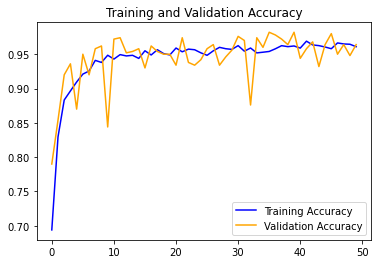

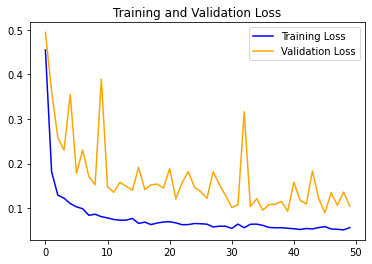

<Figure size 432x288 with 0 Axes>

In [61]:
#Evaluating the loss and accuracy of the model
evaluate_nn(history_9)

### Validation Predictions

In [62]:
#Getting the confusion matrix predictions from the model
cm9_val = get_confusion_matrix(model_9, validation_generator)
cm9_val

array([[154, 154],
       [143, 165]], dtype=int64)

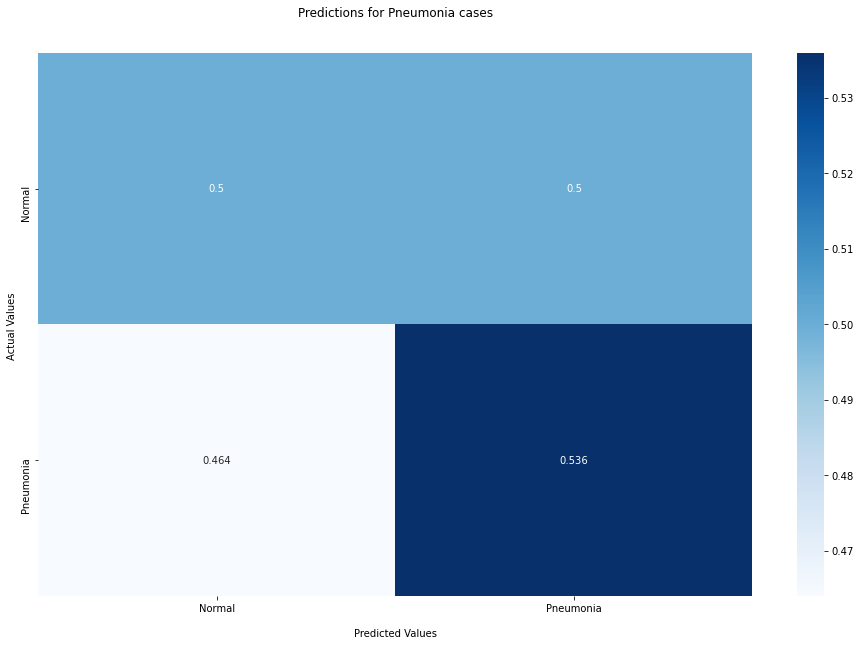

In [63]:
#Creating a plot for the confusion matrix
plot_confusion_matrix(cm9_val)

## Model 10 

Using baseline model:
* One CNN layer: Node = 32
* One Dense hidden layer: Node = 256
* One Dense output layer: Node = 1
* Optimizer = RMSProp
* Learning rate = 1e-4

Keeping: 
* Different regularizer = L2(0.001)

With this model, it will be adjusted with: 
* A new input CNN layer with double nodes
* An additional CNN layer with half nodes
* An additional Dense layer with half nodes
* An additional Dense layer with quarter nodes
* L2 regularizer for each new layer

In [64]:
#Initializing model
model_10 = models.Sequential()

#Adding CNN input layer with L2
model_10.add(layers.Conv2D(64, (3,3), activation = 'relu', kernel_regularizer=regularizers.l2(0.001), input_shape = (150, 150, 3)))
model_10.add(layers.MaxPooling2D(2,2))

#Adding CNN layer with L2
model_10.add(layers.Conv2D(32, (3,3), kernel_regularizer=regularizers.l2(0.001), activation = 'relu'))
model_10.add(layers.MaxPooling2D(2,2))

#Adding CNN layer with L2
model_10.add(layers.Conv2D(16, (3,3), kernel_regularizer=regularizers.l2(0.001), activation = 'relu'))
model_10.add(layers.MaxPooling2D(2,2))

#Flattening and adding Dense layer with L2
model_10.add(layers.Flatten())
model_10.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), activation = 'relu'))

#Adding Dense layer with L2
model_10.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation = 'relu'))

#Adding Dense layer with L2
model_10.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation = 'relu'))

#Adding output layer
model_10.add(layers.Dense(1, activation = 'sigmoid'))

#Compiling model
model_10.compile(loss= 'binary_crossentropy', 
optimizer= optimizers.Adam(lr=0.001), 
metrics=['acc'])

In [65]:
#Fitting model
history_10 = model_10.fit(
    train_generator, #Using train data
    steps_per_epoch=100, #Keeping 100 steps
    epochs=50, #Keeping 50 epochs
    validation_data=validation_generator, #Using validation data
    class_weight = class_weight, #Adding weights to deal with imbalance
    validation_steps=25)#Keeping 25 steps

Epoch 1/50
100/100 [==============================] - 25s 253ms/step - loss: 0.5017 - acc: 0.5565 - val_loss: 0.6317 - val_acc: 0.7600
Epoch 2/50
100/100 [==============================] - 25s 253ms/step - loss: 0.2131 - acc: 0.8495 - val_loss: 0.4214 - val_acc: 0.8460
Epoch 3/50
100/100 [==============================] - 25s 250ms/step - loss: 0.1316 - acc: 0.9235 - val_loss: 0.1884 - val_acc: 0.9520
Epoch 4/50
100/100 [==============================] - 25s 252ms/step - loss: 0.1066 - acc: 0.9360 - val_loss: 0.2627 - val_acc: 0.9240
Epoch 5/50
100/100 [==============================] - 25s 249ms/step - loss: 0.0982 - acc: 0.9354 - val_loss: 0.2090 - val_acc: 0.9380
Epoch 6/50
100/100 [==============================] - 25s 248ms/step - loss: 0.0806 - acc: 0.9560 - val_loss: 0.1896 - val_acc: 0.9380
Epoch 7/50
100/100 [==============================] - 26s 255ms/step - loss: 0.0732 - acc: 0.9594 - val_loss: 0.1394 - val_acc: 0.9580
Epoch 8/50
100/100 [==============================] - 2

In [129]:
#Checking model summary to see how many params will be trained
model_10.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 72, 72, 32)        18464     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 34, 34, 16)        4624      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 17, 17, 16)        0         
_________________________________________________________________
flatten_43 (Flatten)         (None, 4624)            

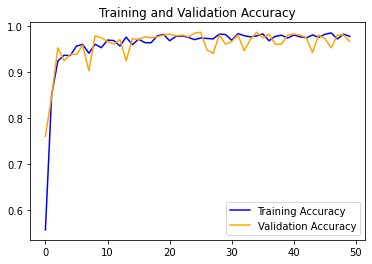

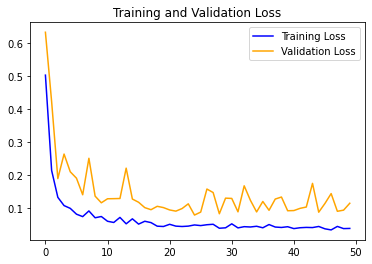

<Figure size 432x288 with 0 Axes>

In [66]:
#Evaluating the loss and accuracy of the model
evaluate_nn(history_10)

### Validation Predictions

In [67]:
#Getting the confusion matrix predictions from the model
cm10_val = get_confusion_matrix(model_10, validation_generator)
cm10_val

array([[141, 167],
       [155, 153]], dtype=int64)

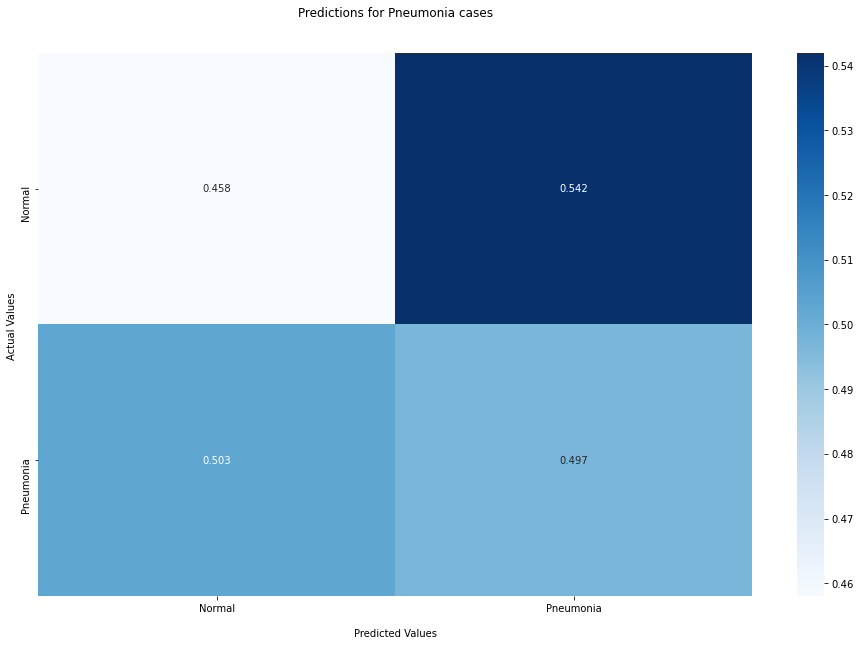

In [68]:
#Creating a plot for the confusion matrix
plot_confusion_matrix(cm10_val)

## Final Model Evaluation

In [70]:
#Scaling test data
test_datagen = ImageDataGenerator(rescale = 1./255)

#Creating a generator for test data
test_generator = test_datagen.flow_from_directory(test_directory,
                                                   target_size = (150, 150),
                                                   batch_size=20,
                                                   class_mode = 'binary')


Found 624 images belonging to 2 classes.


In [72]:
#Evaluating best model on test data
test_loss, test_acc = resnet_model.evaluate(test_generator, steps = 25)
print('Test Accuracy: ', test_acc)

25/25 [==============================] - 8s 308ms/step - loss: 0.5200 - acc: 0.7320
Test Accuracy:  0.7319999933242798


### Final Test Prediction

In [75]:
#Saving best model
resnet_model.save('final_model.h5')

In [117]:
#Checking the classification of the information
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

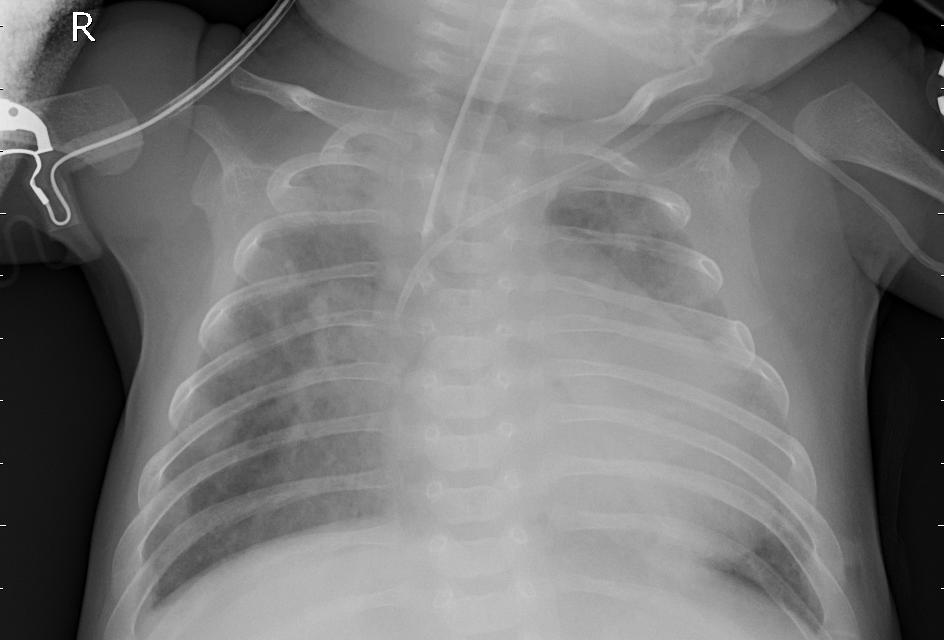

In [90]:
from tensorflow.keras.preprocessing import image

#Displaying a photo of a pneumonia picture from the test set
img_path_pn = "data/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg"
Load_image_pn = tf.keras.preprocessing.image.load_img(img_path_pn)
Load_image_pn

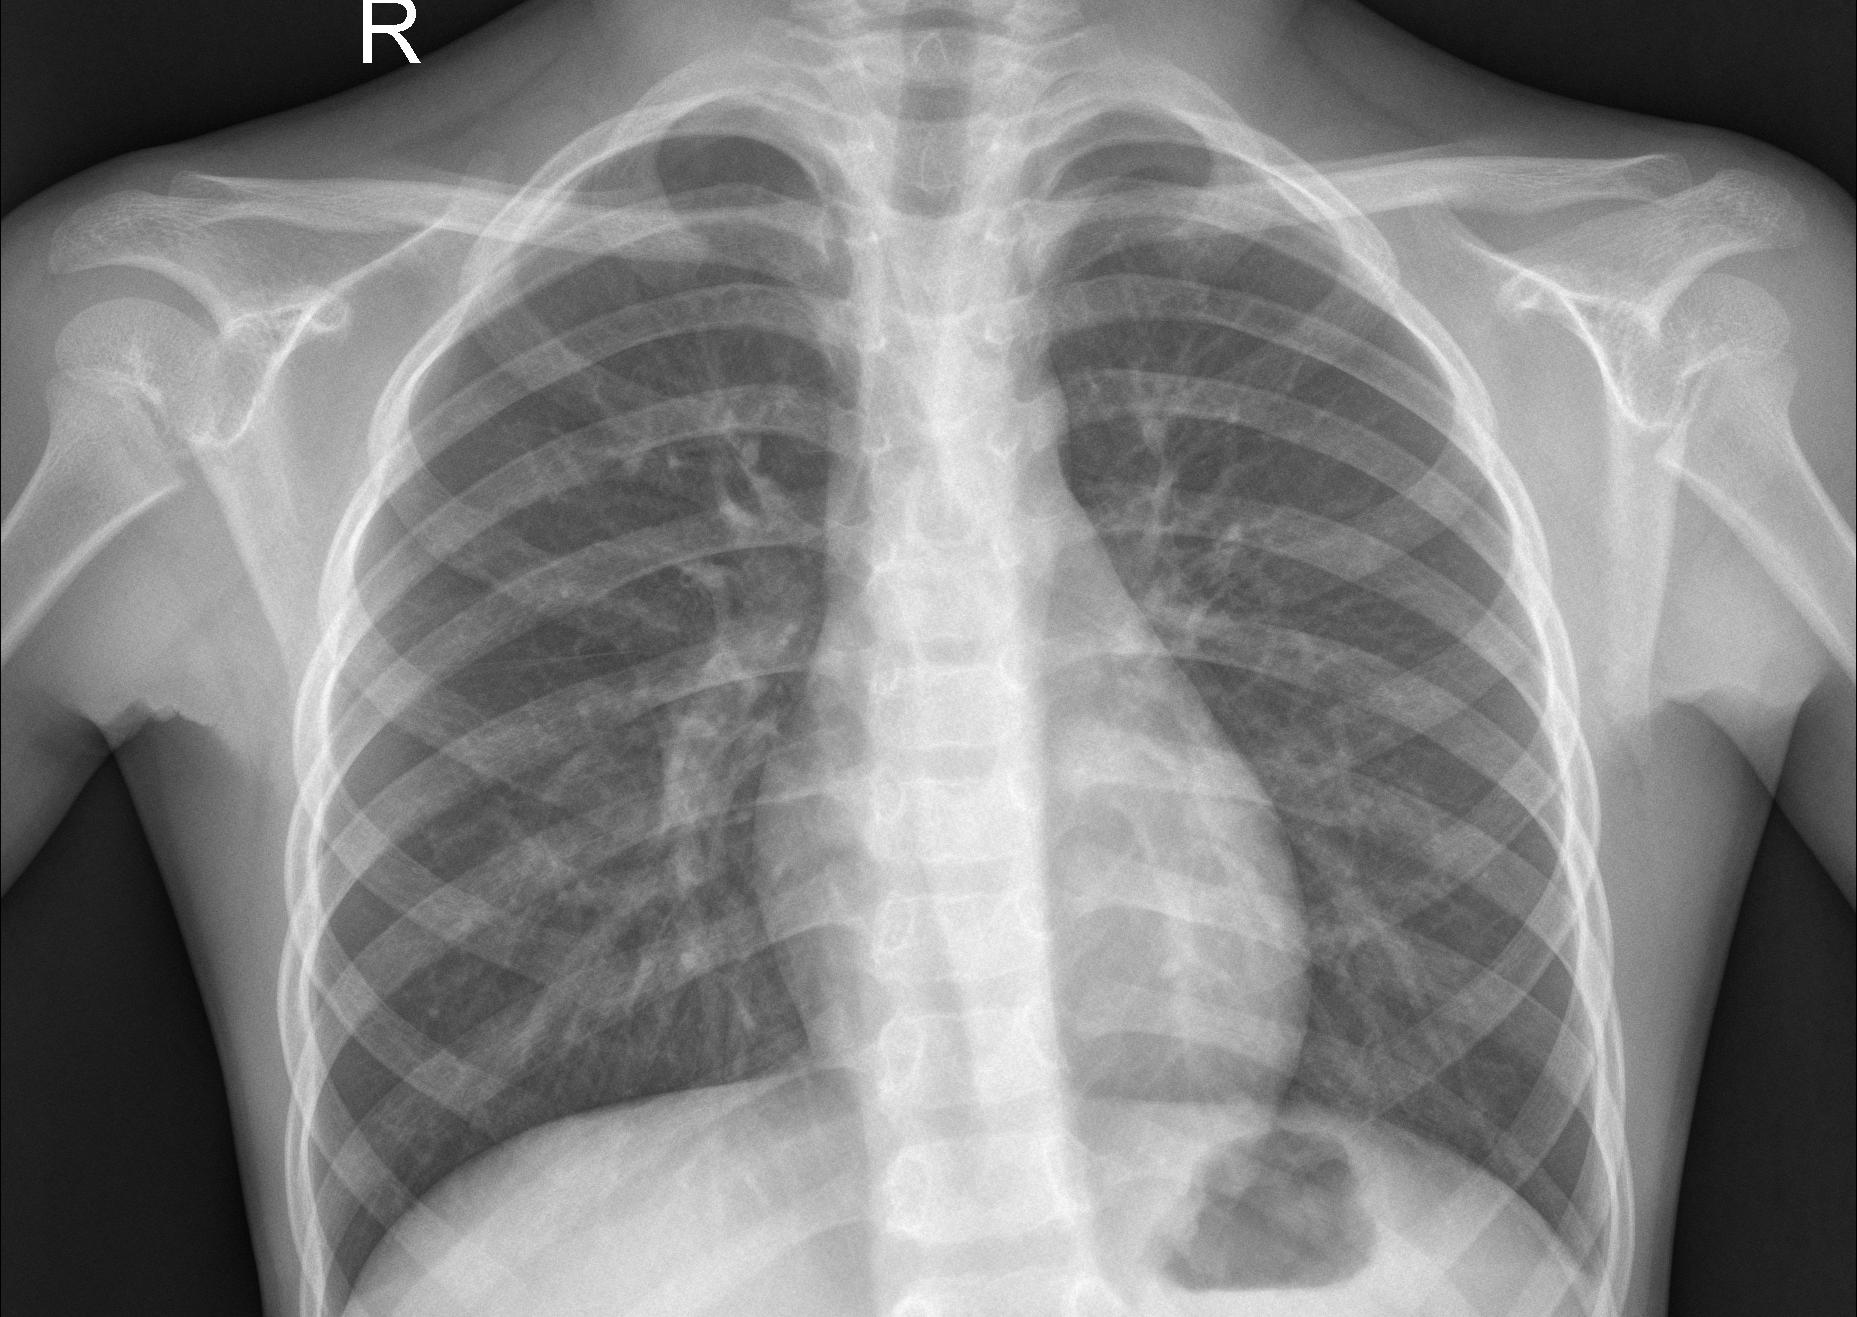

In [130]:
#Displaying a photo of a pneumonia picture from the test set
img_path_nm = "data/chest_xray/test/Normal/IM-0001-0001.jpeg"
Load_image_nm = tf.keras.preprocessing.image.load_img(img_path_nm)
Load_image_nm

In [102]:
#Getting predictions for the test data
pred=resnet_model.predict(test_generator)
#printing the first element from predicted data
print(pred[0])
print('Index:',np.round(pred[0]))

[0.17947078]
Index: [0.]


In [116]:
#Getting predicted values that were generated for the data
y_classes = [int(np.round(element)) for element in pred]

print('Predicted_values:', y_classes[:10])
print('Actual_values:',test_generator.classes[:10])

Predicted_values: [0, 1, 0, 0, 1, 0, 0, 1, 0, 0]
Actual_values: [0 0 0 0 0 0 0 0 0 0]


### Final Confusion Matrix to see the full performance on the test set

In [73]:
#Getting the confusion matrix predictions from the model
cm_final = get_confusion_matrix(resnet_model, test_generator)
cm_final

array([[134, 100],
       [249, 141]], dtype=int64)

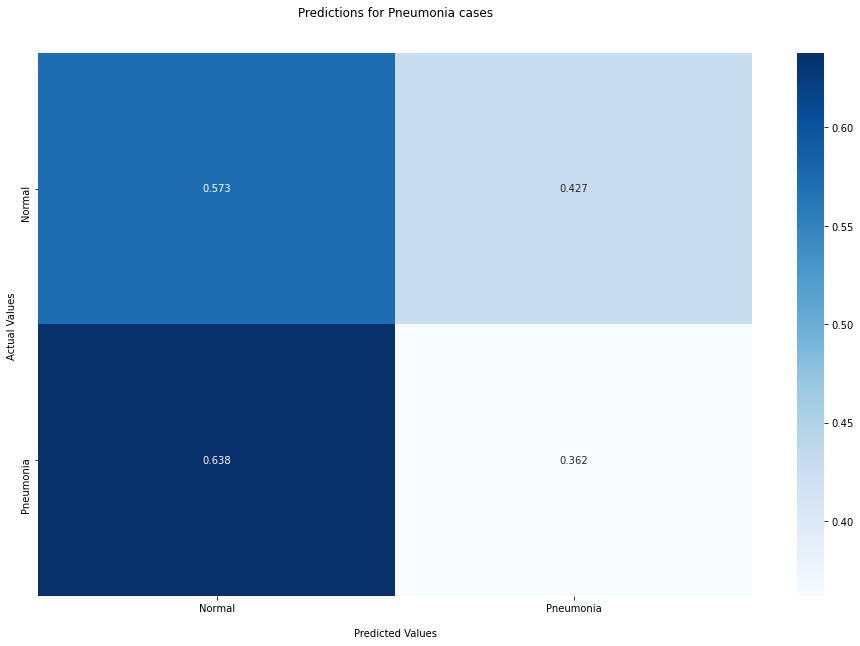

In [74]:
#Creating a plot for the confusion matrix
plot_confusion_matrix(cm_final)